In [1]:
from keras.models import model_from_json
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense,Activation,Flatten,Dropout,Conv2D, MaxPooling2D, Concatenate
import keras.backend.tensorflow_backend as tfback
import tensorflow as tf

import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import tarfile
import wget

from Bio import Seq, SeqRecord, SeqIO
import gffutils
import logging
import numpy as np
import pandas as pd
from os.path import join
import os

# Necessary to keep matplotlib from crashing for some strange reason
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


In [2]:
#####################
# Variables
#####################
filterATG = False
filter_different_signs = False
summarize_gene=False
# adtnl_features = ["LR_T0", "LR_T3", "LR_T6", "LR_T9", "LR_T12", "LR_T15", "LR_T18", "LR_T21",
#                   "LR_T24", "LR_T27", "LR_T30", "GC1", "GC2", "UTR_Length1", "UTR_Length2"]
# adtnl_features = ["GC1", "GC2", "UTR_Length1", "UTR_Length2"]
# n_adtnl = len(adtnl_features)

bp_length = 503  # Length of the sequences that will be one-hot encoded
feature_bp = 50 # Length of UTR adjacent to start codon that will go into the model
genotypes = ("B73", "Mo17", "P39", "CML103")

In [3]:
#####################
# Paths
#####################
# Yeast weights downloaded from :
yeast_url = "https://github.com/Seeliglab/2017---Deep-learning-yeast-UTRs/raw/master/Results/Random_UTR_CNN_Hyperparams.tar.gz"
cup_dir = "../../data/cuperus/"
# data_path_base = "data/filtered_formatted_sequences_logRatios_for_5prime_model"
# if filterATG:
#     data_path_base = data_path_base+"_filterATG"
# if filter_different_signs:
#     data_path_base = data_path_base+"_filterSign"
# if summarize_gene:
#     data_path_base = data_path_base+'_summarizeGene'
# data_path = data_path_base+".pkl"

# Path to reference genomes and annotations for getting UTR sequence
ref_dir = "/media/jlg374/Data1/protein_diverse_maize/references/"

# Path to proteomic comparisons
protein_path = "../../data/fourGenos_peptidePairs_abundance_RNA_allTissues.txt"

In [4]:
#####################
# Functions
#####################

def count_codons(seq, gene_id):
    # Counts the number of each codon in a sequence, starting
    #  from the first base pair and stopping when it reaches
    #  the end (ignores any hanging sequence of <3bp at end.)
    CodonsDict = {"Gene": gene_id, "CDS_Length": len(seq),
          "TTT": 0, "TTC": 0, "TTA": 0, "TTG": 0, "CTT": 0,
          "CTC": 0, "CTA": 0, "CTG": 0, "ATT": 0, "ATC": 0,
          "ATA": 0, "ATG": 0, "GTT": 0, "GTC": 0, "GTA": 0,
          "GTG": 0, "TAT": 0, "TAC": 0, "TAA": 0, "TAG": 0,
          "CAT": 0, "CAC": 0, "CAA": 0, "CAG": 0, "AAT": 0,
          "AAC": 0, "AAA": 0, "AAG": 0, "GAT": 0, "GAC": 0,
          "GAA": 0, "GAG": 0, "TCT": 0, "TCC": 0, "TCA": 0,
          "TCG": 0, "CCT": 0, "CCC": 0, "CCA": 0, "CCG": 0,
          "ACT": 0, "ACC": 0, "ACA": 0, "ACG": 0, "GCT": 0,
          "GCC": 0, "GCA": 0, "GCG": 0, "TGT": 0, "TGC": 0,
          "TGA": 0, "TGG": 0, "CGT": 0, "CGC": 0, "CGA": 0,
          "CGG": 0, "AGT": 0, "AGC": 0, "AGA": 0, "AGG": 0,
          "GGT": 0, "GGC": 0, "GGA": 0, "GGG": 0}

    codons = (seq.seq[n:n + 3] for n in range(0, len(seq), 3))
    for codon in codons:
        if len(codon) < 3:
            break
        CodonsDict[codon] += 1

    return CodonsDict

def pull_utr_sequences(gff_db, reference, bp_upstream, bp_downstream):
    CDSs = []
    ids = []
    upstream5 = []
    downstream3 = []
    # upstream5_str = []
    start_codons = []
    stop_codons = []
    codon_cts = []
    i = 1
    for gene in gff_db.features_of_type('gene'):
        if i % 10000 == 0: print("{} genes done...".format(str(i)))

        gene_id = gene.attributes['ID'][0].replace("gene:", "")

        # Only use the first transcript for each gene. Get the CDS by
        #  gluing together all the cds chunks from the gff file and reverse
        #  complementing if on the negative strand.
        transcript = next(gff_db.children(gene, featuretype="mRNA"))
        cds = SeqRecord.SeqRecord(Seq.Seq(''))
        cds_start = np.inf  # Initialize these to inf so any position will be smaller.
        cds_end = -np.inf   # Initialize these to inf so any position will be smaller.
        for cds_chunk in gff_db.children(transcript, featuretype="CDS", order_by = 'start'):
            cds += reference[cds_chunk.seqid][cds_chunk.start - 1:cds_chunk.end]
            cds_start = min(cds_start, cds_chunk.start)
            cds_end   = max(cds_end,   cds_chunk.end)

        if transcript.strand == "-":
            cds = cds.reverse_complement()

        # Set these regardless of orientation.  Differences in orientation are handled
        #  later.
        cds.start = cds_start
        cds.end = cds_end
        cds.strand = transcript.strand
        cds.seqid = transcript.seqid

        # Record the start and stop codons so I can check later that they look right
        start_of_cds = cds.seq[0:3]
        end_of_cds = cds.seq[-3:]

        # Get 'bp_upstream' base pairs of sequence that ends with the start codon
        # Get 'bp_downstream' base pairs of sequence that starts with the stop codon
        # This is an alternative to grabbing the annotated UTR, since those are of varying
        #  lengths and annotation quality is also probably variable.
        # This makes assumptions about the length of important sequence, but only relies on
        #  good annotation of the CDS start.
        if cds.strand == "+":
            upstream_of_cds = reference[cds.seqid][(cds.start - bp_upstream - 1):(cds.start+2)]
            downstream_of_cds = reference[cds.seqid][(cds.end - 3):(cds.end + bp_downstream)]
        elif cds.strand == "-":
            upstream_of_cds = reference[cds.seqid][(cds.end - 3):(cds.end + bp_upstream)].reverse_complement()
            downstream_of_cds = reference[cds.seqid][(cds.start - bp_downstream - 1):(cds.start+2)].reverse_complement()
        else: # This might not be necessary
            upstream_of_cds = "NNN"
            downstream_of_cds = "NNN"

        # Skip this gene if the CDS has 'N's in it.
        if 'N' in cds:
            continue

        # Append gene id, start/stop codons, and upstream/downstream sequence to their
        #  respective lists.
        ids.append(gene_id)
        start_codons.append(start_of_cds)
        stop_codons.append(end_of_cds)
        upstream5.append(upstream_of_cds)
        downstream3.append(downstream_of_cds)
        CDSs.append(cds)

        # Count codon usage in CDS:
        # If the annotated CDS is not a multiple of 3bp, will drop the last codon
        # More specifically, there is a 'break' if any codon of <3bp is encountered.
        codon_cts.append(pd.DataFrame(count_codons(cds, gene_id), index=[i]))
        i += 1
        
    return ids, start_codons, stop_codons, upstream5, downstream3, CDSs, codon_cts

def read_utrs(utr_path, bp_length):
    # Quick function that, given a file path and expected sequence length,
    #  will read in the sequences from that path.  Expects one column with
    #  gene name, and one column with bp_length base pairs of sequence.
    #  Removes any rows where the sequence is not bp_length long.
    seqs = pd.read_csv(utr_path, sep="\t", names=("Gene", "Sequence"))
    seq_len = seqs.Sequence.str.len()

    # Remove entries with less than `bp_length` basepairs of sequence
    seqs = seqs.loc[seq_len == bp_length, :]
    return seqs


# Small function to one hot encode a string
def encode_seq(sequence, dict):
    return np.transpose([dict[n] for n in sequence])
    # Little test of one-hot encoding
    # encode_seq('AACTTG', one_hot_nuc)


# This is necessary to be able to load the old yeast model when using
#  a newer version of Keras
def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

def cuperus_model():
    yeast = model_from_json(open(YEAST_MODEL).read())
    yeast.load_weights(YEAST_WEIGHTS)

    input_layer = Input(shape=[4, 70, 1])
    model = Conv2D(128, (4, 13), padding="valid", activation='relu')(input_layer)
    model = Dropout(0.15)(model)
    model = Conv2D(128, (1, 13), padding="same", activation='relu')(model)
    model = Dropout(0.15)(model)
    model = Conv2D(128, (1, 13), padding="same", activation='relu')(model)
    model = Dropout(0.15)(model)
    model = Flatten()(model)
    model = Dense(64, activation="relu")(model)
    output = Dense(1)(model)

    new_model = Model(inputs=input_layer, outputs=output)

    weights = yeast.get_weights()
    new_model.set_weights(weights)
    for layer in range(len(new_model.layers)):
        new_model.layers[layer].trainable = False
        # print(new_model.layers[layer].trainable_weights) # Just to make sure nothing is trainable
    return new_model

## Extract UTR sequence from fastas

In [5]:
method = "utr"
bp_upstream = 500 # Will produce sequeces of length 503 = 500bp upstream + 3bp start of CDS
bp_downstream = 500 # Similar to above

for genotype in genotypes:
    # In files
    annotation = join(ref_dir, genotype, "annotation.gff")
    genome = join(ref_dir, genotype, "genome.fa")
    utr_info = join(ref_dir, genotype, "UTR_info.txt")
    # Out files
    upstream5_out = join(ref_dir, genotype, "5_upstreamFromStart_"+str(bp_upstream)+"bp.txt")
    downstream3_out = join(ref_dir, genotype, "3_downstreamFromStart_"+str(bp_downstream)+"bp.txt")
    UTRs5_out = join(ref_dir, genotype, "5_UTR.fa")
    UTRs3_out = join(ref_dir, genotype, "3_UTR.fa")
    codon_cts_out = join(ref_dir, genotype, "codon_counts.txt")
    
    # The Mo17 gff is messed up - UTRs are annotated as e.g. 'five_P00rime_UTR'.
    #  Replace 'five_P00rime_UTR' with 'five_prime_UTR', and similar for 3prime.
    if genotype == "Mo17":
        os.system("gsed -i s/five_P00rime_UTR/five_prime_UTR/ "+annotation)
        os.system("gsed -i s/three_P00rime_UTR/three_prime_UTR/ "+annotation)

    # create the gffutils database in memory from the reference annotation
    # logging.info('Building GFF database in memory')
    print("Loading GFF into memory")
    gff_db = gffutils.create_db(annotation, ':memory:', merge_strategy='create_unique')
    
    # build an in-memory reference sequence dict
    reference = {}
    # logging.info('Loading reference sequence')
    print("Loading reference sequence")
    for record in SeqIO.parse(genome, 'fasta'):
        reference[record.id] = record
    
    # Get sequence upstream and downstream of genes. As well as CDS sequence and codon counts
    ids, start_codons, stop_codons, upstream5, downstream3, CDSs, codon_cts = pull_utr_sequences(gff_db, reference, bp_upstream, bp_downstream)

    # Write out upstream and downstream sequence
    with open(upstream5_out, 'w') as f:
        for name, seq in zip(ids, upstream5):
            f.write('%s\t%s\n' % (name, str(seq.seq)))
    f.close()
    with open(downstream3_out, 'w') as f:
        for name, seq in zip(ids, downstream3):
            f.write('%s\t%s\n' % (name, str(seq.seq)))
    f.close()
    
    # Write out codon counts - these will be used in 3_codon_usage.ipynb
    codon_cts = pd.concat(codon_cts)
    codon_cts.to_csv(codon_cts_out, sep="\t", index=False)


Loading GFF into memory
Loading reference sequence
10000 genes done...
20000 genes done...
30000 genes done...
40000 genes done...
Loading GFF into memory
Loading reference sequence
10000 genes done...
20000 genes done...
30000 genes done...
Loading GFF into memory
Loading reference sequence
10000 genes done...
20000 genes done...
30000 genes done...
40000 genes done...
Loading GFF into memory
Loading reference sequence
10000 genes done...
20000 genes done...
30000 genes done...
40000 genes done...


In [6]:
# # Code below is for sanity check:
# #  1 - Are the sections of 5' upstream sequence the right length?
# #    A: Yes - most are 503bp.  A few are not, possibly due to being near end of chromosome?
# #  2 - Am I hitting the start of the CDS correctly?
# #    A: Yes, the majority of the sequences end with 'ATG' - the start codon.
# upstream_lengths = [len(upstream5[i]) for i in range(len(upstream5))]
# downstream_lengths = [len(downstream3[i]) for i in range(len(downstream3))]
# start = [str(start_codons[i]) for i in range(len(start_codons))]
# end = [str(stop_codons[i]) for i in range(len(stop_codons))]

# # Check distribution of 5' sequence lengths
# bp, bp_ct = np.unique(upstream_lengths, return_counts=True)
# for i in range(len(bp)):
#     print(str(bp[i])+"\t"+str(bp_ct[i]))
# # Check distribution of 3' sequence lengths
# bp, bp_ct = np.unique(downstream_lengths, return_counts=True)
# for i in range(len(bp)):
#     print(str(bp[i])+"\t"+str(bp_ct[i]))
# # # Check distribution of the first 3bp of CDS
# codon, codon_ct = np.unique(start, return_counts=True)
# for i in range(len(codon)):
#     print(str(codon[i])+"\t"+str(codon_ct[i]))
# # # Check distribution of last 3bp of CDS
# codon, codon_ct = np.unique(end, return_counts=True)
# for i in range(len(codon)):
#     print(str(codon[i])+"\t"+str(codon_ct[i]))
    
# # Check last 3bp of unpstream seq
# codon, codon_ct = np.unique([s.seq[:3] for s in downstream3], return_counts=True)
# for i in range(len(codon)):
#     print(str(codon[i])+"\t"+str(codon_ct[i]))

 ## One-hot encode the 5' UTR sequences

In [7]:
# Define the one-hot encoding dictionary.  This could be changed
#  with relative ease to allow for different encodings of N, for
#  example.
one_hot_nuc = {'A':[1,0,0,0],
               'C':[0,1,0,0],
               'G':[0,0,1,0],
               'T':[0,0,0,1],
               'N':[0,0,0,0]}

# Read in 5' sequence and gene names for each of the genotypes,
# and put them in a list
seqs = list()
for geno in genotypes:
    utr_path = ref_dir+'{}/5_upstreamFromStart_{}bp.txt'.format(geno, bp_upstream)
    this_seq = read_utrs(utr_path, bp_length)
    seqs.append(this_seq)

# Concatenate all sequences from the four genotypes into one dataframe
all_seqs = pd.concat(seqs, ignore_index=True)

if filterATG:
    # Subset sequences to only those which end with ATG
    all_seqs = all_seqs.loc[all_seqs.Sequence.str[-3:] == 'ATG']

# Make a dictionary where the gene name is the key and the 5' upstream sequence is the value
seqs_ohe = {all_seqs.Gene[i]: encode_seq(all_seqs.Sequence[i], one_hot_nuc) for i in all_seqs.index}

## Read in peptide data and make X array from one-hot sequences

In [18]:
# Read in peptide abundance comparisons
pep = pd.read_csv(protein_path, sep="\t", header=0)

# 
genes = np.unique([pep.Gene1, pep.Gene2]).tolist()
# print(genes)
genes = [g for g in genes if g in seqs_ohe.keys()]

X = np.empty((len(genes), 4, feature_bp+20, 1))
z = np.zeros((4, 10))
i = 0
for g in genes:
    X[i, :, :, 0] = np.hstack((z, seqs_ohe[g][:, -53:-3], z))
    i = i + 1

## Download and extract files with Cuperus model weights and architecture

In [19]:
YEAST_MODEL = glob.glob(cup_dir+'*/model_arch.json')
YEAST_WEIGHTS = glob.glob(cup_dir+'*/model_weights.h5')
# Download and unpack if model weights/arch don't already exist:
if (not YEAST_MODEL) | (not YEAST_WEIGHTS):
    # Get Cuperus model architecture and weights from github
    wget.download(yeast_url, "../../data/cuperus/")


    my_tar = tarfile.open(cup_dir+'Random_UTR_CNN_Hyperparams.tar.gz', mode='r')
    my_tar.extractall(cup_dir) # specify which folder to extract to
    my_tar.close()

    YEAST_MODEL = glob.glob(cup_dir+'*/model_arch.json')[0]
    YEAST_WEIGHTS = glob.glob(cup_dir+'*/model_weights.h5')[0]

YEAST_MODEL = YEAST_MODEL[0]
YEAST_WEIGHTS = YEAST_WEIGHTS[0]

In [20]:
tfback._get_available_gpus = _get_available_gpus
# Build and compile model
M = cuperus_model()
M.summary()

# Make predictions
preds = pd.DataFrame({'Genes': genes,
                     'Predictions': np.squeeze(M.predict(X))})

# Join preds with pep twice, first on Gene1 then on Gene2
# TODO: drop Genes_x, Genes_y
pep = pd.merge(pep, preds, left_on='Gene1', right_on='Genes').rename(columns={'Predictions':'Pred_Gene1'})
pep = pd.merge(pep, preds, left_on='Gene2', right_on='Genes').rename(columns={'Predictions':'Pred_Gene2'})
pep = pep.drop(columns=['Genes_x', 'Genes_y'])
pep['LR_protein'] = pep.geno1_abundance - pep.geno2_abundance
pep['LR_RNA'] = pep.geno1_RNA - pep.geno2_RNA
pep['Diff_pred'] = pep.Pred_Gene1 - pep.Pred_Gene2
pep

/media/jlg374/Data1/miniconda3/envs/protein_diverse_maize/lib/python3.7/site-packages/keras/engine/base_layer.py:1179: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(name="convolution2d_1", activity_regularizer=None, trainable=True, input_dtype="float32", batch_input_shape=[None, 1, ..., activation="relu", kernel_size=(4, 13), filters=128, strides=[1, 1], padding="valid", data_format="channels_first", kernel_initializer="glorot_uniform", kernel_regularizer=None, bias_regularizer=None, kernel_constraint=None, bias_constraint=None)`
  return cls(**config)
/media/jlg374/Data1/miniconda3/envs/protein_diverse_maize/lib/python3.7/site-packages/keras/engine/base_layer.py:1179: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(trainable=True, name="dropout_1", rate=0.15)`
  return cls(**config)
/media/jlg374/Data1/miniconda3/envs/protein_diverse_maize/lib/python3.7/site-packages/keras/engine/base_layer.py:1179: UserWarning: Update your `Conv2D` call to th

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 4, 70, 1)]        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 58, 128)        6784      
_________________________________________________________________
dropout_9 (Dropout)          (None, 1, 58, 128)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 1, 58, 128)        213120    
_________________________________________________________________
dropout_10 (Dropout)         (None, 1, 58, 128)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 1, 58, 128)        213120    
_________________________________________________________________
dropout_11 (Dropout)         

ID             Protein1             Protein2  n  \
0         [-].MDASAEVDHLAAER.[S]  Zm00001e036430_P003  Zm00040a054821_P001  1   
1        [K].FGSGAYNSMDNGVLR.[F]  Zm00001e036430_P003  Zm00040a054821_P001  1   
2        [K].TDEFVIHSPTLTSSK.[W]  Zm00001e036430_P003  Zm00040a054821_P001  1   
3           [R].LFPLLASAYAFR.[F]  Zm00001e036430_P003  Zm00040a054821_P001  1   
4             [R].LTEEEAGMLR.[L]  Zm00001e036430_P003  Zm00040a054821_P001  1   
...                          ...                  ...                  ... ..   
48474      [R].LSSIGLDNTEVNR.[Q]  Zm00014a041594_P001  Zm00021a025262_P001  1   
48475    [R].RPTTTSAAPTYPNR.[MV]  Zm00014a021172_P001  Zm00021a056915_P003  1   
48476       [R].SVVADPDDLRGK.[T]  Zm00014a043653_P001  Zm00021a014393_P001  1   
48477  [R].TSLNFPTPVRLWGSPTR.[D]  Zm00014a012593_P003  Zm00021a046118_P002  1   
48478       [R].TVLDKPSTHLGR.[T]  Zm00014a013102_P001  Zm00021a043919_P001  1   

       geno1_abundance  geno2_abundance geno1   geno2           Gene1  \
0             7.312679         7.233423   B73     P39  Zm00001e036430   
1             6.893293         6.935752   B73     P39  Zm00001e036430   
2             7.194370         7.301352   B73     P39  Zm00001e036430   
3             7.374826         7.531100   B73     P39  Zm00001e036430   
4             7.052525         6.986405   B73     P39  Zm00001e036430   
...                ...              ...   ...     ...             ...   
48474         6.558791         6.511099  Mo17  CML103  Zm00014a041594   
48475         6.260955         6.071676  Mo17  CML103  Zm00014a021172   
48476         7.162402         7.205168  Mo17  CML103  Zm00014a043653   
48477         9.006818         8.610483  Mo17  CML103  Zm00014a012593   
48478         7.155384         7.056966  Mo17  CML103  Zm00014a013102   

                Gene2  ... geno1_RNA  geno2_RNA        H2  nGenos  Intercept  \
0      Zm00040a054821  ...  2.322437   2.210566  0.780701       4   7.266947   
1      Zm00040a054821  ...  2.322437   2.210566  0.678152       4   6.844110   
2      Zm00040a054821  ...  2.322437   2.210566  0.010103       3   7.232851   
3      Zm00040a054821  ...  2.322437   2.210566  0.874789       4   7.404934   
4      Zm00040a054821  ...  2.322437   2.210566  0.924129       4   6.999076   
...               ...  ...       ...        ...       ...     ...        ...   
48474  Zm00021a025262  ...  1.281616   1.269114  0.000000       2   6.586621   
48475  Zm00021a056915  ...  2.387399   2.442737  0.850433       2   6.152458   
48476  Zm00021a014393  ...  0.415530   1.371244  0.476554       2   7.185161   
48477  Zm00021a046118  ...  0.520784   0.360984  0.965728       2   8.829067   
48478  Zm00021a043919  ...  0.216997   1.027781  0.702645       2   7.139202   

       Pred_Gene1  Pred_Gene2  LR_protein    LR_RNA  Diff_pred  
0       -0.698089   -0.306091    0.079256  0.111871  -0.391998  
1       -0.698089   -0.306091   -0.042458  0.111871  -0.391998  
2       -0.698089   -0.306091   -0.106981  0.111871  -0.391998  
3       -0.698089   -0.306091   -0.156274  0.111871  -0.391998  
4       -0.698089   -0.306091    0.066120  0.111871  -0.391998  
...           ...         ...         ...       ...        ...  
48474    0.188222    0.188222    0.047692  0.012503   0.000000  
48475   -0.436958   -0.436958    0.189279 -0.055338   0.000000  
48476   -0.373318   -0.276409   -0.042766 -0.955713  -0.096909  
48477   -0.780247   -0.780247    0.396335  0.159800   0.000000  
48478    0.185649    0.185649    0.098417 -0.810784   0.000000  

[48479 rows x 21 columns]

[Text(0.5, 0, 'RNA Abundance'), None]

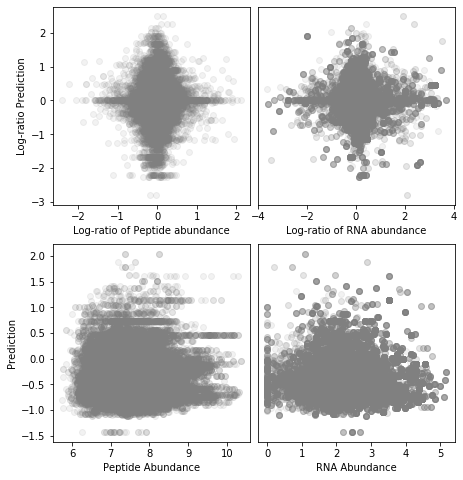

In [32]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

to_plot = pep

fig = plt.figure(figsize=(8, 8))

gs = gridspec.GridSpec(2,2, wspace=-.15)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])

# Plot prediction vs difference between genes
# color = plt.cm.coolwarm(to_plot.H2)
color = "gray"
ax1.scatter(to_plot.LR_protein,
            to_plot.Diff_pred,
            color=color, alpha=0.1)
ax2.scatter(to_plot.LR_RNA,
            to_plot.Diff_pred, 
            color=color,alpha=0.1)
ax3.scatter(to_plot.geno1_abundance,
            to_plot.Pred_Gene1,
            color=color, alpha=0.1)
ax4.scatter(to_plot.geno1_RNA,
            to_plot.Pred_Gene1,
            color=color, alpha=0.1)
ax2.yaxis.set_visible(False)
ax4.yaxis.set_visible(False)

ax1.set(xlabel='Log-ratio of Peptide abundance', ylabel='Log-ratio Prediction', aspect=1.0/ax1.get_data_ratio())
ax2.set(xlabel='Log-ratio of RNA abundance', aspect=1.0/ax2.get_data_ratio())
ax3.set(xlabel='Peptide Abundance', ylabel='Prediction', aspect=1.0/ax3.get_data_ratio())
ax4.set(xlabel='RNA Abundance', aspect=1.0/ax4.get_data_ratio())
